# USA Balancing Authority Mapping
This notebook maps the biggest cities in each balancing authority to each other

In [2]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from itertools import permutations, combinations
import matplotlib.pyplot as plt
import requests
from pathlib import Path
import zipfile

## Helper Functions

In [3]:
def download_file(url: str, destination: str):
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully to {destination}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [4]:
def file_exists(file_path: str):
    path = Path(file_path)
    return path.is_file()

In [5]:
def extract_zip(zip_file_path: str, extract_to: str):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Zip file '{zip_file_path}' extracted successfully to '{extract_to}'")

## Get Balancing Authority Shapes 
Shapes are taken from [Electricity Maps](https://github.com/electricitymaps/electricitymaps-contrib/blob/master/web/geo/world.geojson), as they have a spatially resolved file (ie. no overlaps between balancing authorities)

In [6]:
geojson = "world.geojson"

if not file_exists(geojson):
    url = "https://raw.githubusercontent.com/electricitymaps/electricitymaps-contrib/master/web/geo/world.geojson"
    download_file(url, geojson)

gdf = gpd.read_file(geojson)
gdf = gdf[gdf["countryKey"] == "US"]
gdf.head(5)

,zoneName,countryKey,countryName,geometry
287,US-AK,US,United States,"MULTIPOLYGON (((-139.06039 59.99977, -139.1827..."
288,US-CAL-BANC,US,United States,"MULTIPOLYGON (((-123.03663 40.36388, -122.6946..."
289,US-CAL-CISO,US,United States,"MULTIPOLYGON (((-123.39303 41.16099, -123.4794..."
290,US-CAL-IID,US,United States,"MULTIPOLYGON (((-114.75544 32.64156, -114.5261..."
291,US-CAL-LDWP,US,United States,"MULTIPOLYGON (((-118.65899 34.16872, -118.3961..."


<Axes: >

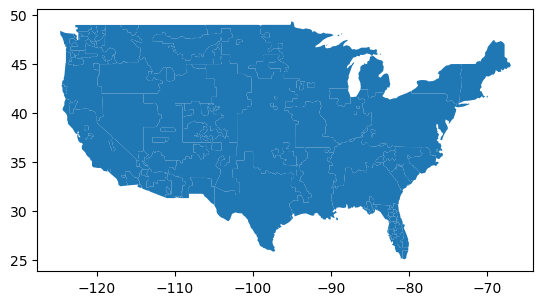

In [7]:
bas = gdf.copy()
bas["region"] = bas["zoneName"].map(lambda x: x.split("-")[1])
bas = bas[~bas["region"].isin(["AK", "HI"])].drop(columns=["region"]) # drop alaska and hawaii
bas.plot()

## Get Population Data
Population data comes from the [World Cities Database](https://simplemaps.com/data/world-cities)

In [8]:
pop_path = Path("worldcities/worldcities.csv")

if not file_exists(pop_path):
    url = "https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip"
    download_file(url, "worldcities.zip")
    extract_zip("worldcities.zip", "worldcities")
    
df = pd.read_csv(pop_path)
df = df[(df["iso3"] == "USA") & (~df["admin_name"].isin(["Hawaii", "Alaska"]))]
df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871.0,1840034016
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244.0,1840020491
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181.0,1840000494
100,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945.0,1840015149
104,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165.0,1840019440


In [9]:
# reformat dataframe
pop = df.copy()
pop["geometry"] = [Point(x,y) for x,y in zip(df["lng"], df["lat"])]
pop = pop[["city", "population", "geometry"]]

# manually adjust miami point, as it falls just outside of the geojson provided 
# original coords are (-80.21010 25.78400)
miami = [["Miami", 5711946.0, Point(-80.3, 25.78400)]]
miami = pd.DataFrame(miami, columns=["city", "population", "geometry"])
pop = gpd.GeoDataFrame(pd.concat([pop, miami]), crs="EPSG:4326").sort_values(by=["population"], ascending=False)
pop = pop[~((pop["city"] == "Miami") & (pop["population"] == 5711945.0))].reset_index(drop=True)

pop.head()

,city,population,geometry
0,New York,18972871.0,POINT (-73.92490 40.69430)
1,Los Angeles,12121244.0,POINT (-118.40680 34.11410)
2,Chicago,8595181.0,POINT (-87.68660 41.83750)
3,Miami,5711946.0,POINT (-80.30000 25.78400)
4,Dallas,5668165.0,POINT (-96.76670 32.79350)


## Find biggest city per balancing authority 

In [10]:
cities = bas.sjoin(pop).drop(columns=["countryName", "countryKey", "index_right"]).reset_index(drop=True)
largest_cities = cities.sort_values(by=["population"], ascending=False)
largest_cities = largest_cities.drop_duplicates(subset=["zoneName"])
largest_cities.head()

,zoneName,geometry,city,population
4269,US-NY-NYIS,"MULTIPOLYGON (((-78.95365 42.93884, -78.86059 ...",New York,18972871.0
491,US-CAL-LDWP,"MULTIPOLYGON (((-118.65899 34.16872, -118.3961...",Los Angeles,12121244.0
2326,US-MIDA-PJM,"MULTIPOLYGON (((-76.55297 35.43809, -76.26856 ...",Chicago,8595181.0
977,US-FLA-HST,"MULTIPOLYGON (((-80.88381 25.18725, -80.64261 ...",Miami,5711946.0
5176,US-TEX-ERCO,"MULTIPOLYGON (((-97.02637 28.11238, -97.16317 ...",Dallas,5668165.0


## Format data to follow database naming conventions 

In [11]:
city_2_point = pop.copy()
# only keep the biggest of duplicate cities 
city_2_point = city_2_point.drop_duplicates(subset=["city"]).set_index("city").to_dict()["geometry"] 

In [12]:
region_ba_map = pd.read_csv("./ba-mapper.csv")
region_ba_map.head()

,code,custom_node_code,region-ba,region,ba,Unnamed: 5
0,USABA,USAWE,CAL-BANC,CAL,BANC,1
1,USACI,USAWE,CAL-CISO,CAL,CISO,1
2,USAII,USAWE,CAL-IID,CAL,IID,1
3,USALD,USAWE,CAL-LDWP,CAL,LDWP,1
4,USATI,USAWE,CAL-TIDC,CAL,TIDC,1


In [18]:
ba_2_code = region_ba_map.set_index("ba").to_dict()["code"]
# code_2_region = region_ba_map.set_index("code").to_dict()["region-ba"]

In [14]:
ba_point = largest_cities.copy()
ba_point = ba_point[["zoneName", "city", "population"]]
ba_point["ba"] = ba_point["zoneName"].map(lambda x: x.split("-")[-1])
ba_point["code"] = ba_point["ba"].map(ba_2_code)
ba_point["geometry"] = ba_point["city"].map(city_2_point)
ba_point.head()

,zoneName,city,population,ba,code,geometry
4269,US-NY-NYIS,New York,18972871.0,NYIS,USANY,POINT (-73.9249 40.6943)
491,US-CAL-LDWP,Los Angeles,12121244.0,LDWP,USALD,POINT (-118.4068 34.1141)
2326,US-MIDA-PJM,Chicago,8595181.0,PJM,USAPJ,POINT (-87.6866 41.8375)
977,US-FLA-HST,Miami,5711946.0,HST,USAHS,POINT (-80.3 25.784)
5176,US-TEX-ERCO,Dallas,5668165.0,ERCO,USAER,POINT (-96.7667 32.7935)


## Correct for where BA does not have a city
In these cases, the geometric centroid is used 

In [23]:
missing = bas.copy()
missing["ba"] = missing["zoneName"].map(lambda x: x.split("-")[-1])
missing = [x for x in missing["ba"].to_list() if x not in ba_point["ba"].to_list()]
missing

['YAD', 'DOPD']

In [27]:
to_add = bas.copy()
to_add["ba"] = to_add["zoneName"].map(lambda x: x.split("-")[-1])
to_add["code"] = to_add["ba"].map(ba_2_code)
to_add = to_add[to_add["ba"].isin(missing)]
data = []
for _, row in to_add.iterrows():
    data.append([
        "",
        "",
        row["code"], 
        row["geometry"].centroid
    ])
gdf_to_add = gpd.GeoDataFrame(data, columns=["city","population","code","geometry"], crs="EPSG:4326")
gdf_to_add.head()

,city,population,code,geometry
0,,,USAYA,POINT (-80.09857 35.51914)
1,,,USADO,POINT (-119.61108 48.24115)


## Export Data

In [28]:
final = ba_point.copy()
final = final[["city", "population", "code", "geometry"]]
final = gpd.GeoDataFrame(final, crs="EPSG:4326")
final = gpd.GeoDataFrame(pd.concat([final, gdf_to_add]), crs="EPSG:4326")
final.head()

,city,population,code,geometry
4269,New York,18972871.0,USANY,POINT (-73.92490 40.69430)
491,Los Angeles,12121244.0,USALD,POINT (-118.40680 34.11410)
2326,Chicago,8595181.0,USAPJ,POINT (-87.68660 41.83750)
977,Miami,5711946.0,USAHS,POINT (-80.30000 25.78400)
5176,Dallas,5668165.0,USAER,POINT (-96.76670 32.79350)


In [29]:
final.shape

(56, 4)

In [32]:
final_csv = final.copy()
final_csv["x"] = round(final_csv["geometry"].x, 4)
final_csv["y"] = round(final_csv["geometry"].y, 4)
final_csv["country"] = "United States"
final_csv = final_csv[["code", "country", "city", "population", "x", "y"]]
final_csv.to_csv("usa-centerpoints.csv", index=False)

<Axes: >

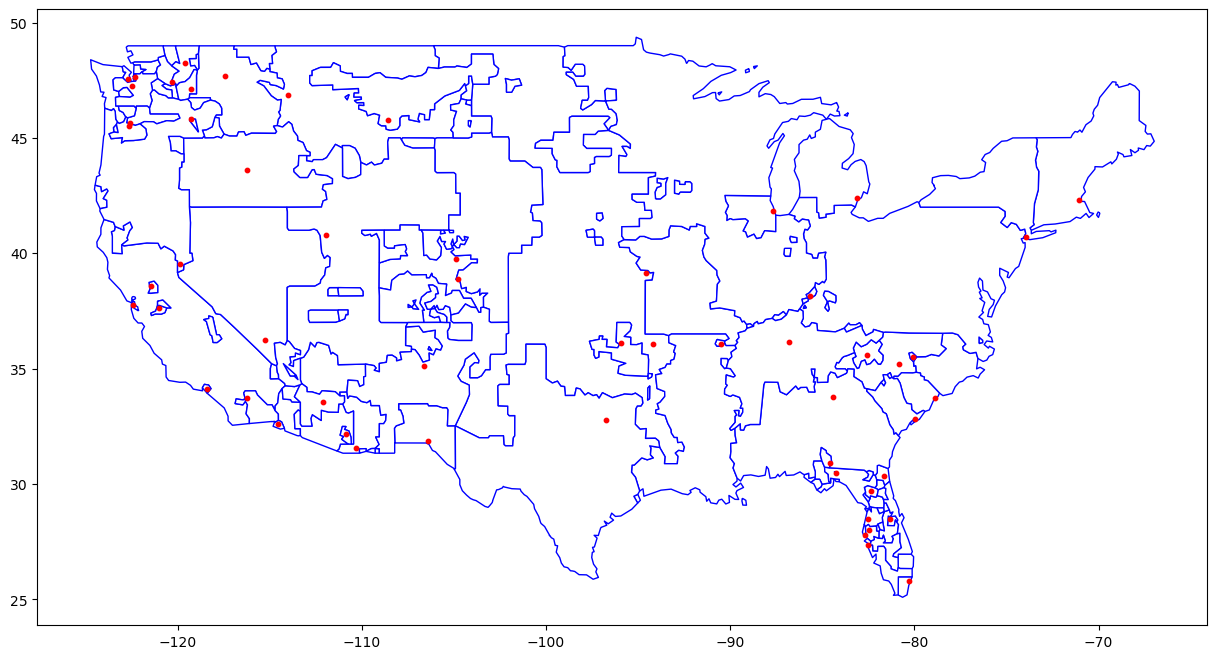

In [30]:
fig, ax = plt.subplots(figsize=(18,8))
bas.plot(
    ax=ax,
    facecolor="white",
    edgecolor="b"
)
final.plot(
    ax=ax,
    color ="r",
    markersize=10
)